# Replication of "Estimating Treatment Effects with Causal Forests: An Application"

## Group 6:
- Claudia Vivas
- Eljaer Eusebio
- Andre Tapia
- Luis Sandoval

This article aims to make an analysis of the National Study of Learning Mindset dataset using the causal forest method to estimate heterogeneous treatment effects. In this way, this research is an empirical application of the causal forest since the Atlantic Causal Inference Conference was interested in methods for heterogeneous treatment effect estimation in observational studies. The National Study of Learning Mindset was a randomized study applied to U.S. public high schools whose purpose was to promote a growth mindset to students. Before using causal forest for estimation, the authors note that the dataset presented two methodological challenges. First, the dataset seems to have some selection bias, for this reason, this research assumes unconfoundness by using instruments to conduct sensitivity for hidden confounding. Second, the students are not independently sampled, instead, they were selected from 76 randomly schools, which generates heterogeneity across schools, so the researchers apply cluster-robust analysis tools to take account of the sample variability of potentially unexplained school-level effects. 

In [1]:
set.seed(1)

rm(list = ls())

library(grf)
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

Warning message:
"package 'grf' was built under R version 3.6.3"
Warning message:
"package 'lmtest' was built under R version 3.6.3"
Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'Hmisc' was built under R version 3.6.3"
Loading required package: lattice

Loading required package: survival

Warning message:
"package 'survival' was built under R version 3.6.3"
Loading required package: Formula

Warning message:
"package 'Formula' was built under R version 3.6.3"
Loading required package: ggplot2

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units




In [2]:
data.all = read.csv("C:/Users/sniff/Documents/Estadistica aplicada/synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

this database stores 10,391 students in 76 schools with a simulated outcome Y (a continuous measure of achievement), a binary treatment variable Z indicating receipt of the intervention, and the following 10 covariates at both the student and school level:

- $S3$ - Students' self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment
- $C1$ - Categorical variable for student race/ethnicity
- $C2$ - Categorical variable for student identified gender
- $C3$ - Categorical variable for student first-generation status (i.e. first in family to go to college)
- $XC$ - School-level categorical variable for urbanicity of the school (i.e. rural, suburban, etc.)
- $X1$ - School-level mean of students' fixed mindsets, reported prior to random assignment
- $X2$ - School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students
- $X3$ - School racial/ethnic minority composition -- i.e. % black, latino, or native/american
- $X4$ - School poverty concentration -- i.e. % of students who are from families whose incomes fall below the federal poverty line
- $X5$ - School size - Total # of students in all four grade levels in the school

In [3]:
DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

### It appears that school ID does not affect pscore. So ignore it
### in modeling, and just treat it as source of per-cluster error.

In [4]:
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)

W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

### Grow a forest. Add extra trees for the causal forest.

In [5]:
# train Y.forest and W.forest
Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

#Train a first forest on all the features
cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)


selected.idx = which(varimp > mean(varimp))

#Train a second forest on features selected on the previous step
cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions

First of all, this causal forest works with clustered data, so the authors adapt the random forest algorithm as follows. This algorithm stars:
1. Fitting two separate regression forest to estimate $\hat{m}$ (expected outcome marginalizing over treatment) $\hat{e}$ (propensity score). 
2. Then, the algorithm make out-of-bag predictions using regression forest of the previous step. 


In few words, Y.forest and W.forest are trained using default settings, as their predictions are simply used as inputs to the causal forest, also causal forest have several parameters which are selected by cross-validation. That is, starts by training a pilot random forest on all the features, and then train a second forest on only those features that saw a reasonable number of splits.

In [6]:
tau.hat #

[1] 0.2701016 0.2418667 0.2701016 0.2701016 0.2759470 0.2701016 0.2759470
    [8] 0.2759470 0.2562299 0.2759470 0.2562299 0.2606379 0.2759470 0.2759470
   [15] 0.2701016 0.2629129 0.2560236 0.2759470 0.2759470 0.2759470 0.2791804
   [22] 0.2612344 0.2612344 0.2621795 0.2759470 0.2701016 0.2759470 0.2629129
   [29] 0.2759470 0.2612344 0.2612344 0.2488694 0.2612344 0.2621795 0.2531285
   [36] 0.2701016 0.2606379 0.2409152 0.2759470 0.2701016 0.2621795 0.2701016
   [43] 0.2701016 0.2759470 0.2701016 0.2759470 0.2759470 0.2621795 0.2791804
   [50] 0.2612344 0.2612344 0.2621795 0.2701016 0.2701016 0.2759470 0.2409152
   [57] 0.2621795 0.2409152 0.2531285 0.2759470 0.2852509 0.2560236 0.2791804
   [64] 0.2701016 0.2651340 0.2651340 0.2410850 0.2410850 0.2019034 0.2410850
   [71] 0.2019034 0.2213661 0.2027997 0.2651340 0.2213661 0.2019034 0.2410850
   [78] 0.2213661 0.2810118 0.2272226 0.2019034 0.2810118 0.2410850 0.2272226
   [85] 0.2213661 0.2570970 0.2249232 0.2371612 0.2651340 0.2213661 0.2213661
   [92] 0.2410850 0.2570970 0.2651340 0.2410850 0.2213661 0.2213661 0.2570970
   [99] 0.2810118 0.2651340 0.2221555 0.2086891 0.2371612 0.2221555 0.2027997
  [106] 0.2570970 0.2019034 0.2570970 0.2736825 0.2213661 0.2651340 0.2609634
  [113] 0.2019034 0.2213661 0.2213661 0.2470414 0.2470414 0.2390866 0.2592374
  [120] 0.2349436 0.2286719 0.2349436 0.2258558 0.2349436 0.2592374 0.2614250
  [127] 0.2749353 0.2670872 0.2626718 0.2723269 0.2349436 0.2523671 0.2286719
  [134] 0.2463854 0.2258558 0.2285777 0.2390866 0.2626718 0.2371331 0.2592374
  [141] 0.2285777 0.2390866 0.2626718 0.2349436 0.2390866 0.2670872 0.2285777
  [148] 0.2349436 0.2200356 0.2390866 0.2626718 0.2614250 0.2434774 0.2498457
  [155] 0.2236249 0.2390866 0.2390866 0.2523671 0.2723269 0.2592374 0.2626718
  [162] 0.2285777 0.2236249 0.2285777 0.2258558 0.2470414 0.2390866 0.2285777
  [169] 0.2470414 0.2498457 0.2258558 0.2592374 0.2371331 0.2258558 0.2258558
  [176] 0.2258558 0.2470414 0.2286719 0.2670872 0.2285777 0.2498457 0.2614250
  [183] 0.2614250 0.2592374 0.2749353 0.2614250 0.2390866 0.2592374 0.2626718
  [190] 0.2614250 0.2258558 0.2289567 0.2470414 0.2592374 0.2749353 0.2258558
  [197] 0.2285777 0.2825396 0.3050657 0.2768225 0.2808885 0.3043146 0.3050657
  [204] 0.2862064 0.2867763 0.3043146 0.3050657 0.2768225 0.3043146 0.3122920
  [211] 0.3050657 0.3024176 0.3154462 0.2768225 0.3050657 0.3043146 0.3122920
  [218] 0.2808885 0.2808885 0.2862064 0.3043146 0.3050657 0.2785025 0.3122920
  [225] 0.3043146 0.3043146 0.3050657 0.3158066 0.3050657 0.3154462 0.3008368
  [232] 0.3024176 0.2808885 0.3154462 0.2768225 0.2768225 0.3008368 0.2862064
  [239] 0.2729464 0.3043146 0.3043146 0.2785025 0.2808885 0.3008368 0.3154462
  [246] 0.2862064 0.3141342 0.3024176 0.3122920 0.2785025 0.3043146 0.2768225
  [253] 0.3024176 0.2768225 0.2768225 0.3008368 0.2808885 0.3043146 0.3008368
  [260] 0.2768225 0.2808885 0.2768225 0.3043146 0.2618869 0.2867763 0.3043146
  [267] 0.3141342 0.3024176 0.3050657 0.3043146 0.3043146 0.3050657 0.3043146
  [274] 0.3158066 0.3043146 0.3154462 0.3008368 0.2867763 0.3024176 0.3043146
  [281] 0.2301325 0.2468020 0.2403353 0.2403353 0.2491168 0.2468020 0.2454109
  [288] 0.2403353 0.2468020 0.2735500 0.2491168 0.2617743 0.2704977 0.2617743
  [295] 0.2779778 0.2684160 0.2403353 0.2684160 0.2491168 0.2617743 0.2403353
  [302] 0.2486989 0.2617743 0.2485590 0.2642554 0.2403353 0.2301325 0.2356675
  [309] 0.2617743 0.2704977 0.2468020 0.2617743 0.2779778 0.2447281 0.2684160
  [316] 0.2403353 0.2617743 0.2486989 0.2468020 0.2468020 0.2275265 0.2617743
  [323] 0.2403353 0.2486989 0.2617743 0.2454109 0.2468020 0.2486989 0.2301325
  [330] 0.2486989 0.2301325 0.2382825 0.2486989 0.2704977 0.2704977 0.2617743
  [337] 0.2704977 0.2735500 0.2491168 0.2802008 0.2486989 0.2684160 0.2491168
  [344] 0.2486989 0.2802008 0.2617743 0.2288191 0.2704977 0.2301325 0.2486989
  [351] 0.2617743 0.2382825 0.2800478 0.2802864 0.2555281 0.2953725 0.2956128
  [358] 0.2675049 0.280047

After all the process, the CATE are predicted for clusterized causal forests. 

### Estimate ATE

In [7]:
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.248 +/- 0.041"

This sections tries to know the overall effectiveness of the treatment. The resoult says that the estimated ATE is 0.248 with +/- 0.041 of confidence interval, this application suggests that the treatment had a large positive effect on average. 

### Omnibus tests for heterogeneity

### Run best linear predictor analysis

In [8]:
test_calibration(cf)

# Compare regions with high and low estimated CATEs


high_effect = tau.hat > median(tau.hat)

# Estimation of ATE for ate high and low
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.992560   0.082569 12.0210 <2e-16 ***
differential.forest.prediction 0.275835   0.616262  0.4476 0.3272    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "95% CI for difference in ATE: 0.037 +/- 0.074"

Now is important to test the treatment heterogeneity, despite plotting the estimated CATE and noticing there is treatment heterogeneity. There are two approaches to test heterogeneity, The first approach groups observations according to whether their out-of-bag CATE estimates are above or below the median CATE estimate, and then estimating average treatment effects in these two subgroups separately using the doubly robust approach.The second approach tests for heterogeneity by the $best linear predictor$ method. Running both methods, we can conclude that there is heterogeneity, but neither is significant. Thus, at least if we insist on cluster-robust inference, any treatment heterogeneity that may be present appears to be relatively weak, and causal forests do not identify subgroups with effects that obviously stand out. In sum, althought we didn't find strong evidence of treatment heterogeneity, this doesn't implies there isn't heterogeneity. 

In [9]:
#
# formal test for X1 and X2
#

dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])

school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])

school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0796, df = 71.402, p-value = 0.002942
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19481996 -0.04169622
sample estimates:
mean of x mean of y 
0.1885602 0.3068183 



	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 1.0011, df = 72.229, p-value = 0.3201
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04020131  0.12131665
sample estimates:
mean of x mean of y 
0.2679681 0.2274105 


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2  0.085 0.04251   1.377  0.259
Residuals        73  2.254 0.03088               

- For $X1$: we can notice that there is heterogeneity in $X1$ variable.Also, this heterogeneous effect is significant, since it´s condifence interval doesn't contain zero value.  
- For $X2$: there is no very striking heterogeneity, since the estimated coefficient is not significant


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.2544, df = 75, p-value = 0.02709
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.0100095 0.1620529
sample estimates:
 mean of x 
0.08603122 


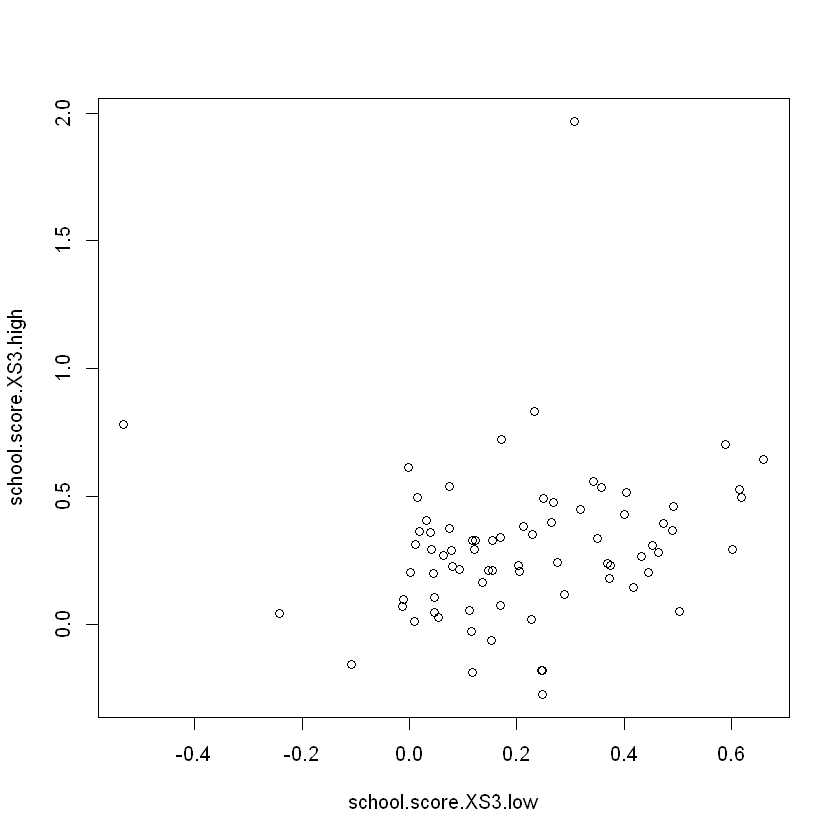

In [10]:
#
# formal test for S3
#

school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)

### Look at school-wise heterogeneity

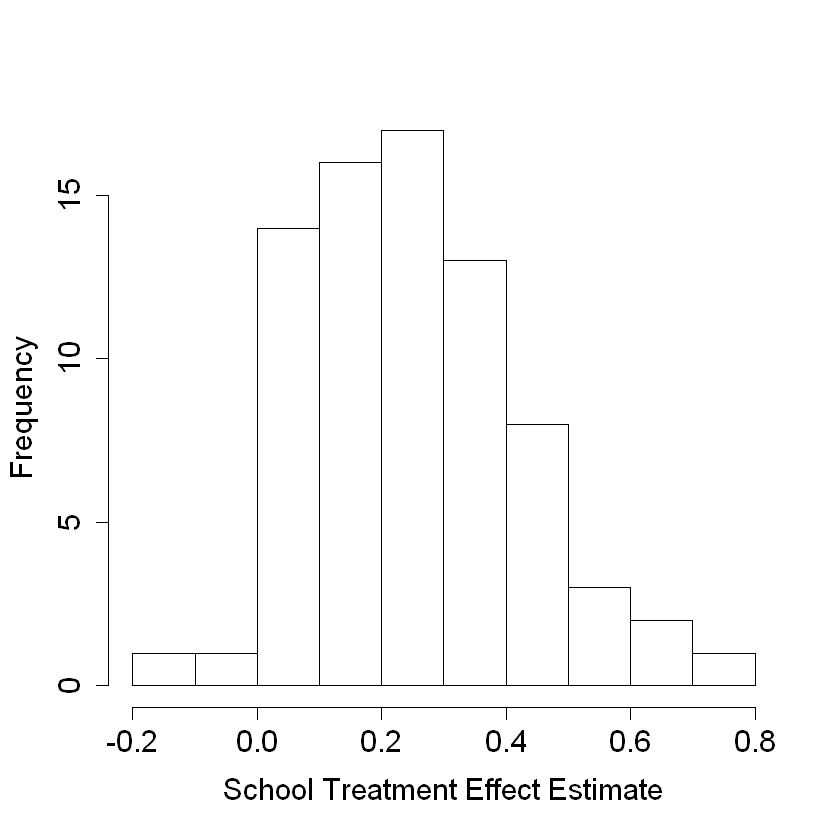

In [11]:
#pdf("school_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
#dev.off()


At the beginning of the article, the authors mentioned that two variables were of interest $X1$ (School-level mean of students' fixed mindsets reported before random assignment) $X2$(School achievement level, both covariates are refere to school-level,  measured by test scores and college preparation for the previous 4 cohorts of students) because of the possible heterogeneity, so it is plausible that a test for heterogeneity that focuses on these two variables may have more power than the approaches developed before. In this way, this graphics depicts heterogenity because the school treatment effect estimate take diferent estimated values. 

In [12]:
#
# Re-check ATE... sanity check only
#

ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.248 +/- 0.04"


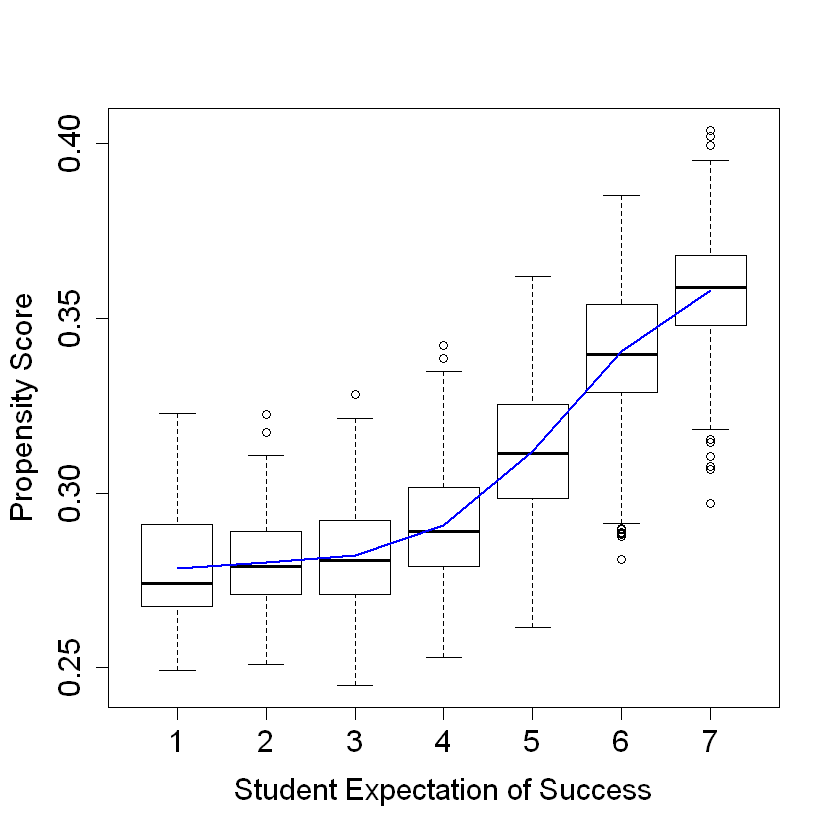

In [13]:
#
# Look at variation in propensity scores
# PAG 3

DF = X
DF$W.hat = cf$W.hat

#pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
#dev.off()

This graphics shows shows that students with higher expectations of success ($S3$) have higher probabilities to recive the treatment $W$.

### Analysis ignoring clusters

[1] "95% CI for the ATE: 0.253 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.009318   0.045006 22.4261 < 2.2e-16 ***
differential.forest.prediction 0.533711   0.123261  4.3299 7.528e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.979843   0.064856 15.1079 <2e-16 ***
differential.forest.prediction 0.147340   0.213052  0.6916 0.2446    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] -3.867459e-05  7.096268e-04

                     Df Sum Sq Mean Sq F value  Pr(>F)    
factor(school.id)    75    203   2.708   1.999 7.3e-07 ***
Residuals         10315  13972   1.355                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

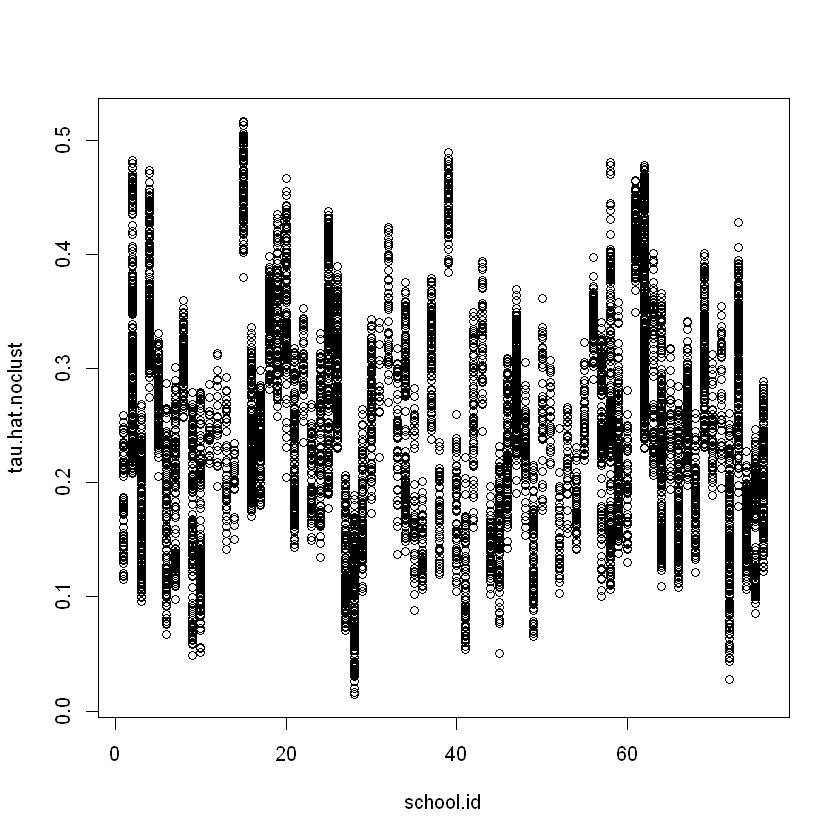

In [14]:
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))

There are two differences between this article analysis and classic causal forest analysis since this article includes cluster-robust methods and orthogonalization for robustness to confounding. In this section, the authors estimate CATE from a non-cluster-robust causal forest. The histogram of the distribution of the CATE estimates with no clustering shows that the variation es vary from 0.26 to 0.36, whereas the cluster-robust estimate of its mean CATE was roughly 0.2.

On the second part of the programming, the data is divided into 5-fold version of causal forest algorithm where the forests themselves are not cluster-robust, but the estimation folds are cluster aligned. First, this algorithm split the schools into 5 folds; then each fold  fit a causal forest without clustering on observations belonging to schools in the 4/5 other folds, and made CATE estimates on the held out fold. 

In sum, while the first method concludes that there is no presence of heterogeneity and the result is far from the causal forest whith clusterization, the second method (5-fold version) a tenous evidence for the presence of heterogeneity is found.In other words, if we use evaluation methods that are robust to clustering, then the apparent gains from non-cluster-robust forests wash away.

### Analaysis without fitting the propensity score

[1] "95% CI for the ATE: 0.254 +/- 0.041"

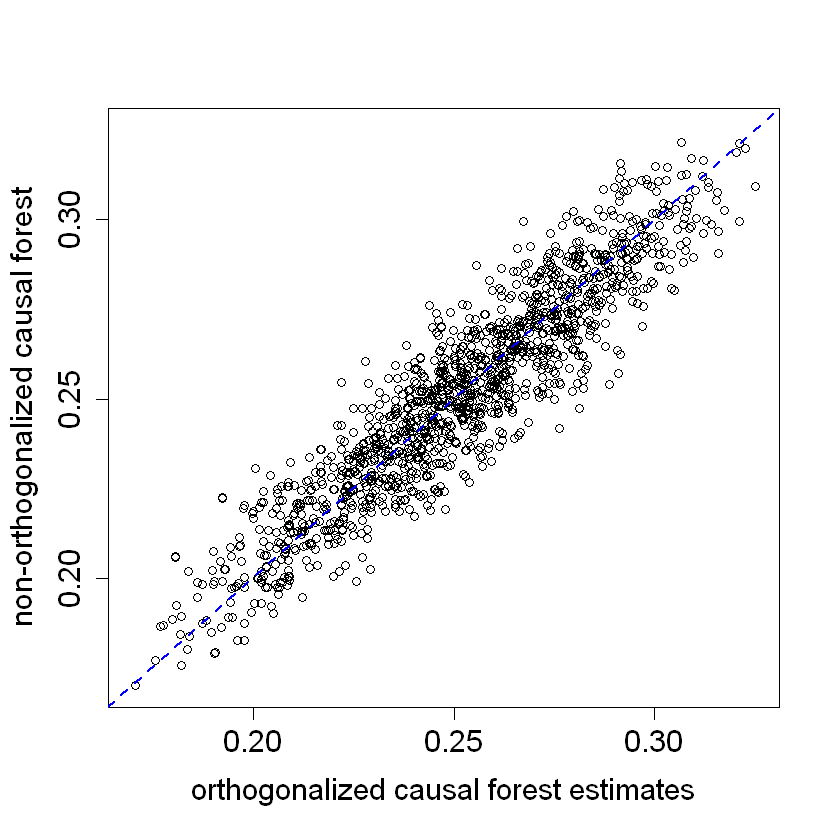

In [15]:
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

#pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
#dev.off()

In this section, authors train a causal forests without estimating the propensity score or, that is to say the default propensity score, and if we estimate CATE with orthogonalization, the CATE estimates using both ways are almost the same using the trivial propensity. That is the causal forests trained with or without orthogonalization yield essentially the same CATE estimatesNevertheless, orthogonalization becomes important when there are some covariates that are highly predictive of treatment propensities but not very predictive of Y. 

The figure above compares the estimates from a forest trained with a trivial propensity score to predictions from the forest trained as in algorithm and uses an orthogonalized propensity score. We can conclude that estimation using both ways is almost the same

In [16]:
#
# Train forest on school-wise DR scores
#

school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.990389   0.082107 12.0622 <2e-16 ***
differential.forest.prediction 0.598579   0.727696  0.8226 0.2067    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [17]:
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)   
(Intercept)  0.24079581  0.07773953  3.0975 0.002866 **
X1          -0.04959039  0.02966052 -1.6719 0.099273 . 
X2           0.01412785  0.03388522  0.4169 0.678081   
X3           0.00939179  0.02683438  0.3500 0.727460   
X4           0.02372228  0.02555013  0.9285 0.356552   
X5          -0.03526586  0.02708329 -1.3021 0.197399   
XC.1         0.00090015  0.09453655  0.0095 0.992432   
XC.2         0.08582749  0.10582788  0.8110 0.420275   
XC.3        -0.13553694  0.08823978 -1.5360 0.129317   
XC.4         0.04492317  0.08222504  0.5463 0.586672   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### The code plot six plots in the Make some plots section, so explain what you find there.
### Make some plots...

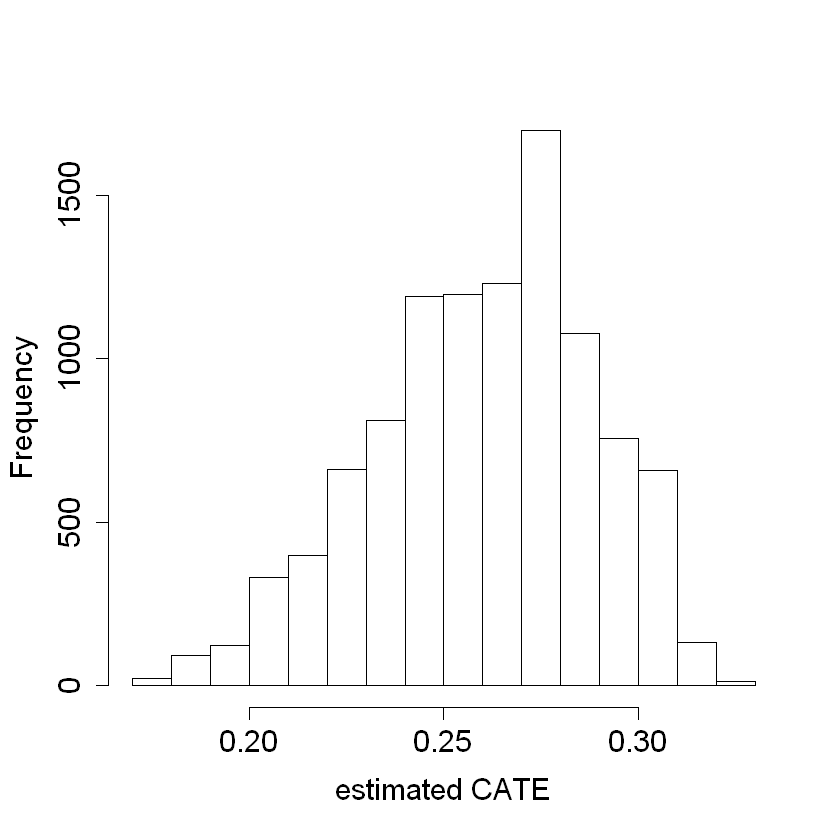

In [18]:
#pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
#dev.off()

Once the causal forest is fitted, is usefull to look the distribution of the prediction to notice if there is heterogeneity. However, the histogram is not recommended as a definitive way to assess heterogeneity, since one might tempted to think "is the histogram is concentrated at a point, then there is no heterogeneity, or if the histogram is spread out, then our estimator has found interesting heterogeneity", however both of this statements might be wrong. In contrast, the correct interpretation of this histogram might be that if histogram is concentrated at a point, then the forest were not able to detect any heterogeneity. On the other hand, is the histogram is spread out, it may be that the forest are simply overfiting anf producing very noisy estimates. 

This histogram shows the distribution of estimated CATE using causal forest algorithmn, this demostrate that there are different heterogeneous effects for different groups, that is, it is not the same effect for all groups. In few words, this histogram demostrate heterogeneity. 

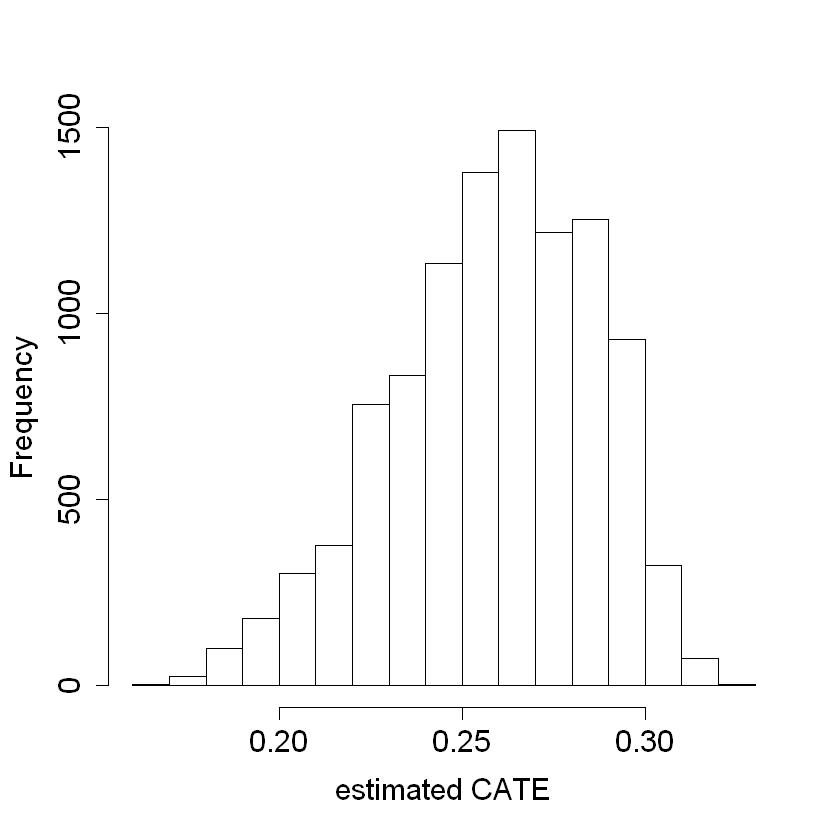

In [19]:
#pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
#dev.off()

This histogram shows the distribution of estimated CATE using trival propensity score, this demostrate that there are different heterogeneous effects for different groups, that is, it is not the same effect for all groups. In few words, this histogram demostrate heterogeneity. 

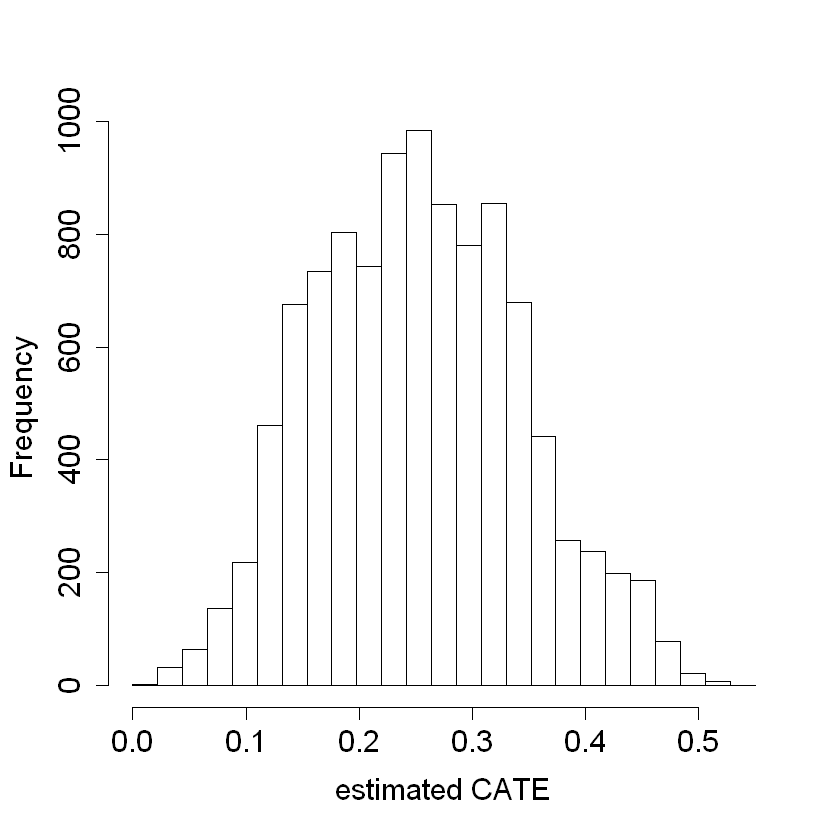

In [26]:
#pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))
#dev.off()

This histogram shows CATE estimates without clustering, that is, trained using a causal forest that does not account for school-level clustering. Unlike the previous figures, the CATE estimates obtained without clustering are much more dispersed than those obtained with clustering. In few words, this histogram doesn't shows heterogeneity. 

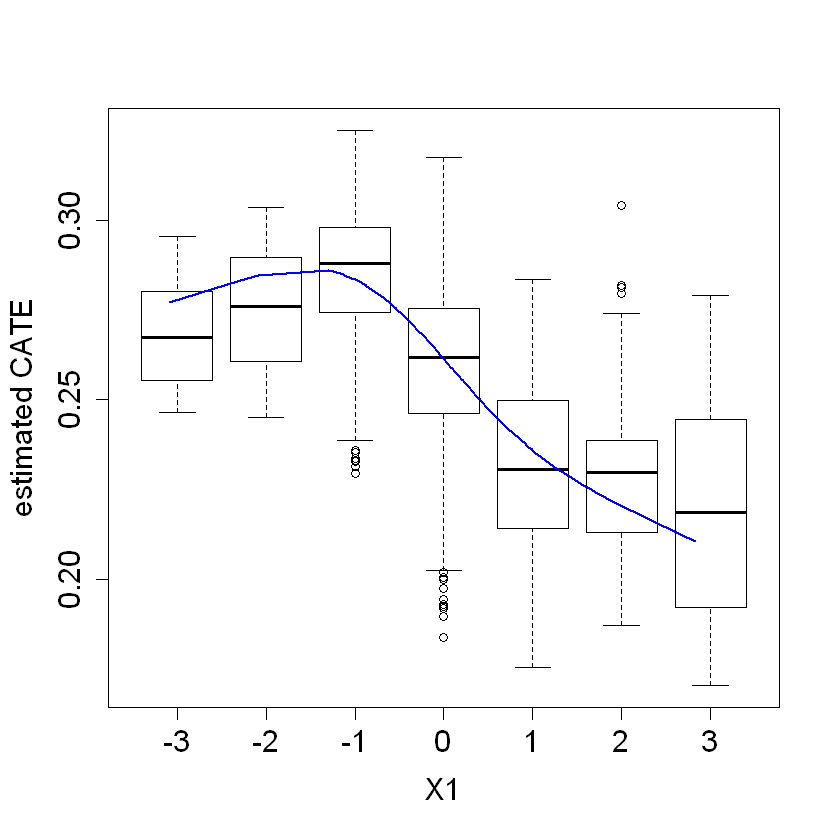

In [22]:
#pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
#dev.off()

This graph shows that if the variable $X1$ (School-level mean of students' fixed mindsets reported before random assignment) is taken into account, it could be concluded that there is heterogeneity, since the subgroups of X1 adopt varied CATEs.  Is important to remember that previously we have showed that heterogeneity along X1 was significant.

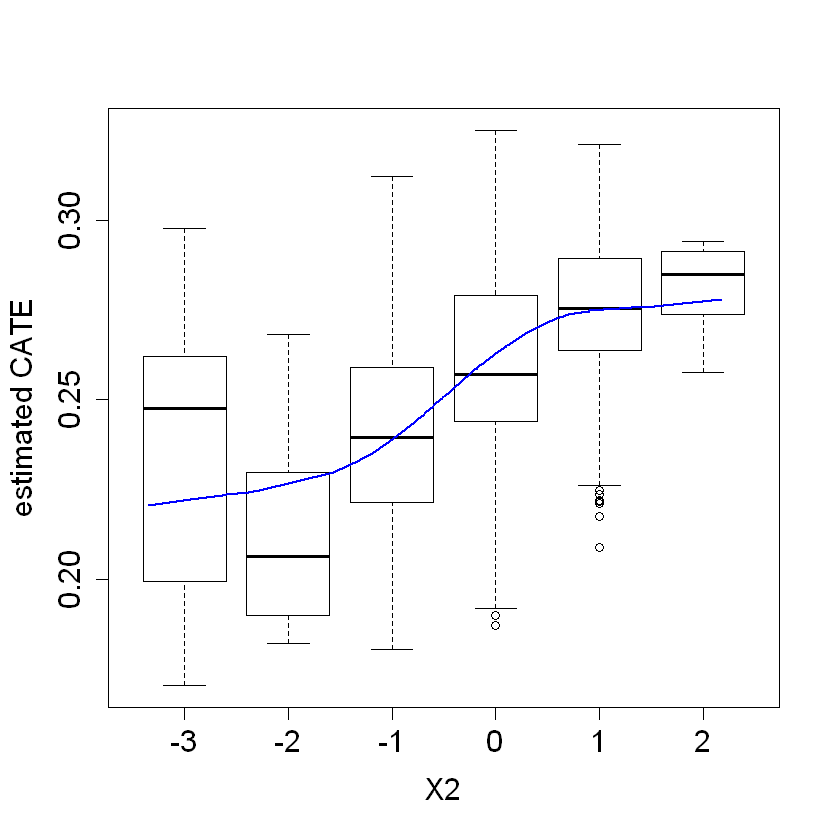

In [23]:
#pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
#dev.off()

This graph shows that if the variable $X2$(School achievement level, both covariates are refere to school-level,  measured by test scores and college preparation for the previous 4 cohorts of students) is taken into account, it could be concluded that there is heterogeneity, since the subgroups of X2 adopt varied CATEs. HOwever, is importand to remind that the heterogeneity along $X2$ was not significant.

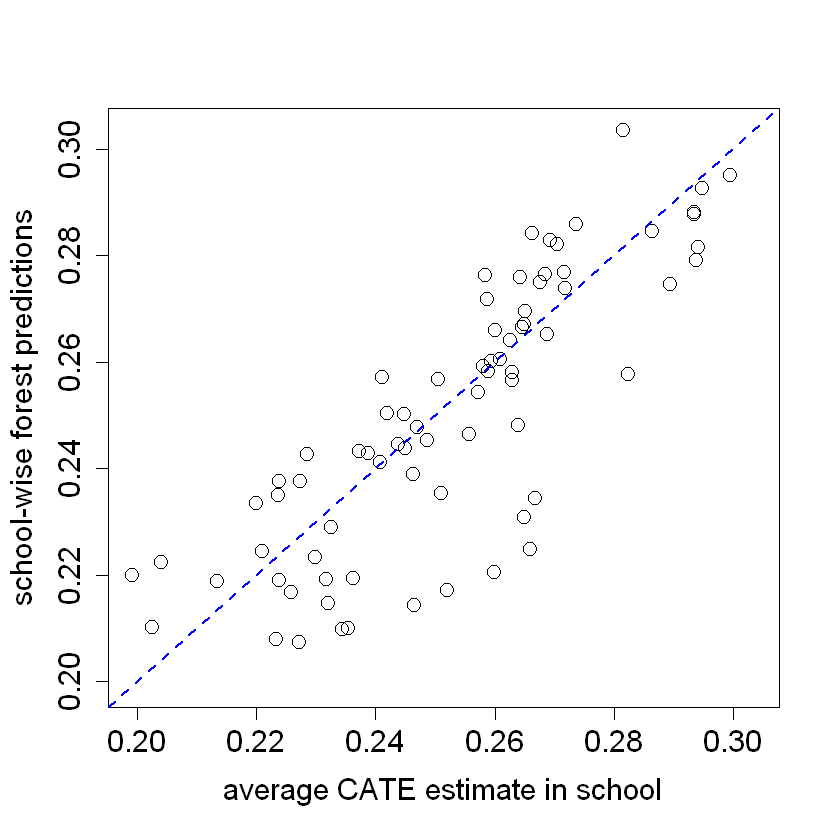

In [24]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

#pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
#dev.off()

This graphics compares average CATE estimate in school to school-wise forest predictions, we can see that the points are not very close to the blue line, in that sense we can conclude that the estimates using these two forms are not the same.

In [25]:
#
# Experiment with no orthogonalization
#

n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))


[1] "95% CI for the ATE: 0.011 +/- 0.15"

[1] "95% CI for the ATE: 0.13 +/- 0.137"

### Visualize school-level covariates by treatment heterogeneity

[1] 0.2105263

[1] 0.5384615

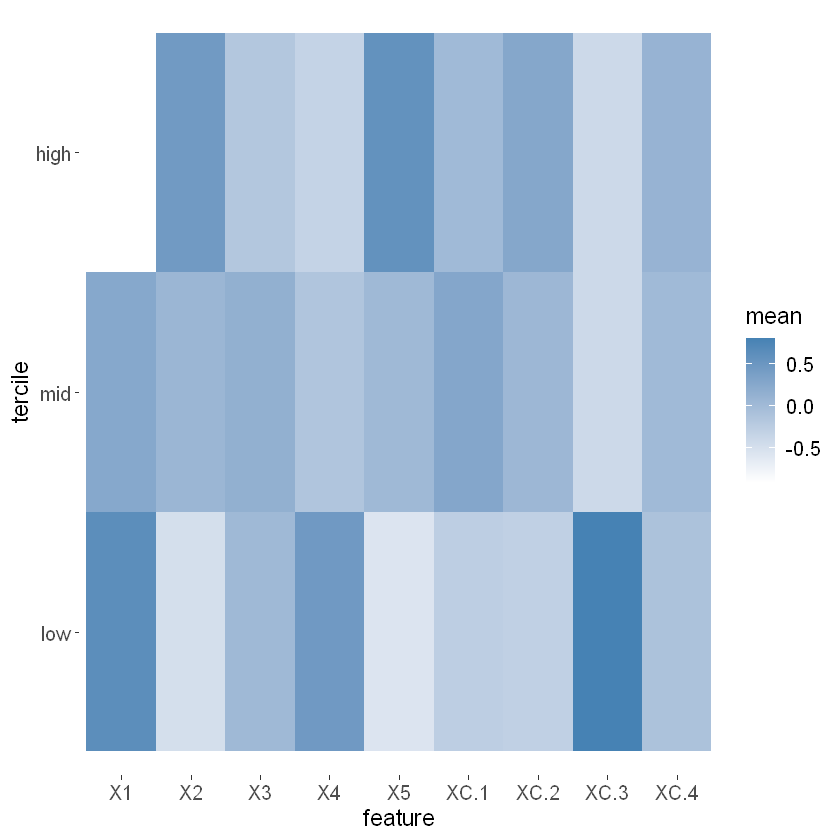

In [27]:
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

This picture visualize the treatment heterogeneity for school-level covariates vs school tercile, splitting the data into groups.It allows us to observe in which groups the HTE was greater or less, in this case we observe that the rectangles where the blue color is darker have a value closer to 0.5 of heteroregoneity in the treatment, on the contrary, the rectangles that are lighter showed a value closer to -0.5 for heterogeneity. In short, this graph allows us to observe the heterogeneous effect of the treatment for different groups, since the rectangles are painted in different colors.

### CATE by school

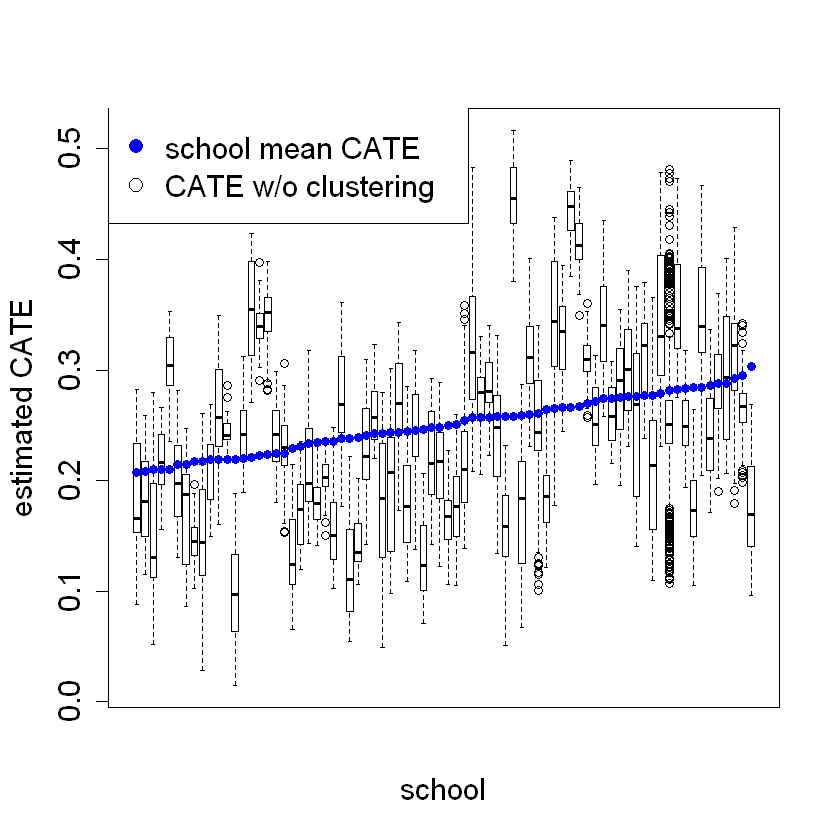

In [28]:
ord = order(order(school.pred))
school.sort = ord[school.id]

#pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
#dev.off()

This graphic compares the CATE from a non-cluster-robust causal forest to per-school mean treatment effect predictions from a forest trained on per-school responses as seen before. This graphic is also explained in "Analysis ignoring clusters" section, however, I would like to complement the explanation with the following: non-cluster-robust forest is able to overfit the treatmente effect to this school-level effect because it does not account for potential correlations between different students in the same school.

## Testing the Convergence Hypothesis

## Introduction

We provide an additional empirical example of partialling-out with Lasso to estimate the regression coefficient $\beta_1$ in the high-dimensional linear regression model:
  $$
  Y = \beta_1 D +  \beta_2'W + \epsilon.
  $$
  
Specifically, we are interested in how the rates  at which economies of different countries grow ($Y$) are related to the initial wealth levels in each country ($D$) controlling for country's institutional, educational, and other similar characteristics ($W$).
  
The relationship is captured by $\beta_1$, the *speed of convergence/divergence*, which measures the speed at which poor countries catch up $(\beta_1< 0)$ or fall behind $(\beta_1> 0)$ rich countries, after controlling for $W$. Our inference question here is: do poor countries grow faster than rich countries, controlling for educational and other characteristics? In other words, is the speed of convergence negative: $ \beta_1 <0?$ This is the Convergence Hypothesis predicted by the Solow Growth Model. This is a structural economic model. Under some strong assumptions, that we won't state here, the predictive exercise we are doing here can be given causal interpretation.

The outcome $Y$ is the realized annual growth rate of a country's wealth  (Gross Domestic Product per capita). The target regressor ($D$) is the initial level of the country's wealth. The target parameter $\beta_1$ is the speed of convergence, which measures the speed at which poor countries catch up with rich countries. The controls ($W$) include measures of education levels, quality of institutions, trade openness, and political stability in the country.

In [29]:
library(hdm)
library(xtable)

Warning message:
"package 'hdm' was built under R version 3.6.3"
Warning message:
"package 'xtable' was built under R version 3.6.3"

Attaching package: 'xtable'


The following objects are masked from 'package:Hmisc':

    label, label<-




In [30]:
# Export data to read in python
GrowthData <- GrowthData
save(GrowthData, file = "C:/Users/sniff/Documents/Estadistica aplicada/GrowthData.RData")

In [31]:
library(hdm)
growth <- GrowthData
attach(growth)
names(growth)

[1] "Outcome"   "intercept" "gdpsh465"  "bmp1l"     "freeop"    "freetar"  
 [7] "h65"       "hm65"      "hf65"      "p65"       "pm65"      "pf65"     
[13] "s65"       "sm65"      "sf65"      "fert65"    "mort65"    "lifee065" 
[19] "gpop1"     "fert1"     "mort1"     "invsh41"   "geetot1"   "geerec1"  
[25] "gde1"      "govwb1"    "govsh41"   "gvxdxe41"  "high65"    "highm65"  
[31] "highf65"   "highc65"   "highcm65"  "highcf65"  "human65"   "humanm65" 
[37] "humanf65"  "hyr65"     "hyrm65"    "hyrf65"    "no65"      "nom65"    
[43] "nof65"     "pinstab1"  "pop65"     "worker65"  "pop1565"   "pop6565"  
[49] "sec65"     "secm65"    "secf65"    "secc65"    "seccm65"   "seccf65"  
[55] "syr65"     "syrm65"    "syrf65"    "teapri65"  "teasec65"  "ex1"      
[61] "im1"       "xr65"      "tot1"

In [32]:
dim(growth)

[1] 90 63

In [33]:
#install.packages('lfe')

In [34]:
library(lfe)

Warning message:
"package 'lfe' was built under R version 3.6.3"
Loading required package: Matrix


Attaching package: 'lfe'


The following object is masked from 'package:lmtest':

    waldtest




## OLS

In [35]:
Y <- growth[, 1, drop = F] # output variable
Z <- as.matrix(growth)[, -c(1, 2,3)] # controls
D <- growth[, 3, drop = F] # target regressor
dim(Z)

[1] 90 60

In [36]:
y <- as.matrix(Y)
d <- as.matrix(D)
z <- as.matrix(Z)
#head(data.frame(cbind(y,d))

In [37]:
#baseline_formula <- as.formula(paste(y, "~", d ))
#baseline.ols <- lm(baseline_formula,data=rdata)

baseline.ols <- lm(Outcome ~ gdpsh465,data=growth)
est_baseline <- summary(baseline.ols)$coef[2,]
confint(baseline.ols)[2,]
est_baseline

2.5 %      97.5 % 
-0.01081013  0.01344355

Estimate  Std. Error     t value    Pr(>|t|) 
0.001316713 0.006102200 0.215776701 0.829661165

In [38]:
summary(baseline.ols)


Call:
lm(formula = Outcome ~ gdpsh465, data = growth)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.147387 -0.024088  0.001209  0.027721  0.139357 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.035207   0.047318   0.744    0.459
gdpsh465    0.001317   0.006102   0.216    0.830

Residual standard error: 0.05159 on 88 degrees of freedom
Multiple R-squared:  0.0005288,	Adjusted R-squared:  -0.01083 
F-statistic: 0.04656 on 1 and 88 DF,  p-value: 0.8297


In [39]:
confint(baseline.ols)[2,]

2.5 %      97.5 % 
-0.01081013  0.01344355

In [40]:
value<- predict(baseline.ols,growth)
difference <- value - growth$Outcome
rmse_ols_y <- sqrt(mean(difference^2))
rmse_ols_y

[1] 0.0510148

In [41]:
value_d<- predict(baseline.ols,growth)
difference_d <- value_d - growth$gdpsh465
rmse_ols_d <- sqrt(mean(difference_d^2))
rmse_ols_d

[1] 7.709105

## OLS contolling countries characteristics

In [42]:
control_formula <- as.formula(paste("Outcome", "~", paste("gdpsh465",paste(colnames(Z),collapse="+"),
                                                          sep="+")))
control_formula

Outcome ~ gdpsh465 + bmp1l + freeop + freetar + h65 + hm65 + 
    hf65 + p65 + pm65 + pf65 + s65 + sm65 + sf65 + fert65 + mort65 + 
    lifee065 + gpop1 + fert1 + mort1 + invsh41 + geetot1 + geerec1 + 
    gde1 + govwb1 + govsh41 + gvxdxe41 + high65 + highm65 + highf65 + 
    highc65 + highcm65 + highcf65 + human65 + humanm65 + humanf65 + 
    hyr65 + hyrm65 + hyrf65 + no65 + nom65 + nof65 + pinstab1 + 
    pop65 + worker65 + pop1565 + pop6565 + sec65 + secm65 + secf65 + 
    secc65 + seccm65 + seccf65 + syr65 + syrm65 + syrf65 + teapri65 + 
    teasec65 + ex1 + im1 + xr65 + tot1

In [43]:
control.ols <- lm(control_formula,data=growth)
est_ols <- summary(control.ols)$coef[2,]
confint(control.ols)[2,]
est_ols

2.5 %      97.5 % 
-0.07060022  0.05184424

Estimate   Std. Error      t value     Pr(>|t|) 
-0.009377989  0.029887726 -0.313773911  0.756018518

In [44]:
summary(control.ols)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.247160893,0.78450163,0.31505466,0.755056170
gdpsh465,-0.009377989,0.02988773,-0.31377391,0.756018518
bmp1l,-0.068862679,0.03253065,-2.11685513,0.043289718
freeop,0.080068974,0.20786400,0.38519885,0.703000838
freetar,-0.488962605,0.41816285,-1.16931143,0.252136477
h65,-2.362098638,0.85729167,-2.75530338,0.010192435
hm65,0.707143400,0.52314511,1.35171560,0.187285919
hf65,1.693448425,0.50318881,3.36543337,0.002232683
p65,0.265526695,0.16429407,1.61616729,0.117271229
pm65,0.136952626,0.15121749,0.90566657,0.372840111


In [45]:
value.control<- predict(control.ols,growth)
difference.control <- value.control - growth$Outcome
rmse_ols_control_y <- sqrt(mean(difference.control^2))
rmse_ols_control_y

[1] 0.01714556

In [46]:
value_control_d<- predict(control.ols,growth)
difference_control_d <- value_control_d - growth$gdpsh465
rmse_ols_control_d <- sqrt(mean(difference_control_d^2))
rmse_ols_control_d

[1] 7.709255

## DML

In [47]:
I_1 <- c(1,2,3,4,5,6,7,8,9,10)
I_2 <- c(11,12,13,14,15,16,17,18,19,20)
I = c(I_1, I_2)
I

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

In [48]:
DML2.for.PLM <- function(z, d, y, dreg, yreg, nfold=2) {
  nobs <- nrow(z) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds  
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(z[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(z[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, z[I[[b]],], type="response") #predict the left-out fold 
    yhat <- predict(yfit, z[I[[b]],], type="response") #predict the left-out fold  
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
        }
  #rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  data <- data.frame(cbind(ytil, dtil))
  rfit <- felm(ytil ~ dtil,data=growth) 
  coef.est <- coef(rfit)[2]  #extract coefficient
  #HC <- vcovHC(rfit)
  se    <- summary(rfit,robust=T)$coefficients[2,2] #record robust standard error by County
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil, rfit=rfit) ) #save output and residuals 
}

## DML Lasso

In [49]:
library(hdm)
library(glmnet)
library(sandwich)
library(randomForest)

Warning message:
"package 'glmnet' was built under R version 3.6.3"
Loaded glmnet 4.1-1

Warning message:
"package 'randomForest' was built under R version 3.6.3"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [50]:
#DML with Lasso:
set.seed(123)
dreg <- function(z,d){ rlasso(z,d, post=FALSE) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=FALSE) } #ML method = lasso from hdm

In [51]:
DML2.lasso = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0370317 (0.0161774)


## DML Lasso Post

In [52]:
#DML with Post-Lasso:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.post = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0368285 (0.0141174)


## DML Ridge

In [53]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.ridge = DML2.for.PLM(z, d, y, dreg, yreg, nfold=5)

fold: 1  2  3  4  5  
coef (se) = -0.03214 (0.0151531)


## DML Elnet

In [54]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0.5) } #ML method = elastic net from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0.5) }  #ML method = elastic net from glmnet 
DML2.elnet = DML2.for.PLM(z, d, y, dreg, yreg, nfold=5)

fold: 1  2  3  4  5  
coef (se) = -0.037759 (0.0171555)


In [55]:
## DML Random Forest

In [56]:
#DML with Random Forest:
dreg <- function(z,d){ randomForest(z, d) } #ML method=Forest 
yreg <- function(z,y){ randomForest(z, y) } #ML method=Forest
set.seed(1)
DML2.RF = DML2.for.PLM(z, d, y, dreg, yreg, nfold=2) # set to 2 due to computation time

fold: 1  2  
coef (se) = -0.0290514 (0.0128382)


In [57]:
if (!is.null(d) && !is.factor(d))
             max(floor(ncol(z)/3), 1) else floor(sqrt(ncol(z)))

[1] 20

In [58]:
if (!is.null(d) && !is.factor(d)) 5 else 1

[1] 5

In [59]:
mods<- list(DML2.lasso, DML2.post, DML2.elnet, DML2.ridge, DML2.RF)

RMSE.mdl<- function(mdl) {
RMSEY <- sqrt(mean(mdl$ytil)^2) 
RMSED <- sqrt(mean(mdl$dtil)^2) 
return( list(RMSEY=RMSEY, RMSED=RMSED))
}

#RMSE.mdl(DML2.lasso)

#DML2.lasso$ytil

Res<- lapply(mods, RMSE.mdl)


prRes.Y<- c( Res[[1]]$RMSEY,Res[[2]]$RMSEY, Res[[3]]$RMSEY, Res[[4]]$RMSEY, Res[[5]]$RMSEY)
prRes.D<- c( Res[[1]]$RMSED,Res[[2]]$RMSED, Res[[3]]$RMSED, Res[[4]]$RMSED, Res[[5]]$RMSED)

prRes<- rbind(prRes.Y, prRes.D); 
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("Lasso", "Post-Lasso",  "CV Elnet", "CV Ridge", "RF")
print(prRes,digit=6)

             Lasso  Post-Lasso    CV Elnet    CV Ridge          RF
RMSE D 0.000831523 0.000333837 3.81930e-18 0.000199755 0.000844267
RMSE Y 0.012439826 0.000541272 1.14092e-02 0.003328221 0.029621814


In [60]:
library(xtable)
table <- matrix(0, 2, 2)
table[1,1:2]   <- c(rmse_ols_d,rmse_ols_y)
table[2,1:2]   <- c(rmse_ols_control_d,rmse_ols_control_y)
colnames(table) <-c("OLS","OLS with countries characteristics")
rownames(table) <-c("RMSE D","RMSE Y")
tab<- xtable(table, digits = 3)
print(tab,type="html") # set type="latex" for printing table in LaTeX
table

<!-- html table generated in R 3.6.1 by xtable 1.8-4 package -->
<!-- Sat Nov 27 16:45:28 2021 -->
<table border=1>
<tr> <th>  </th> <th> OLS </th> <th> OLS with countries characteristics </th>  </tr>
  <tr> <td align="right"> RMSE D </td> <td align="right"> 7.709 </td> <td align="right"> 0.051 </td> </tr>
  <tr> <td align="right"> RMSE Y </td> <td align="right"> 7.709 </td> <td align="right"> 0.017 </td> </tr>
   </table>


,OLS,OLS with countries characteristics
RMSE D,7.709105,0.05101480
RMSE Y,7.709255,0.01714556


## DML Best

It looks like the best method for predicting D is CV Elnet, and the best method for predicting Y is CV Elnet. Because it has the lowest Root Mean Square Error in Y and D matrix variables.

In [61]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0.5) } #ML method = elastic net from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0.5) }  #ML method = elastic net from glmnet 
DML2.best = DML2.for.PLM(z, d, y, dreg, yreg, nfold=5)

fold: 1  2  3  4  5  
coef (se) = -0.038173 (0.0156573)


In [62]:
library(xtable)

table <- matrix(0,8,2)
table[1,1] <- as.numeric(est_baseline[1])
table[2,1] <- as.numeric(est_ols[1])
table[3,1]   <- as.numeric(DML2.lasso$coef.est)
table[4,1]   <- as.numeric(DML2.post$coef.est)
table[5,1]  <as.numeric(DML2.elnet$coef.est)
table[6,1] <-as.numeric(DML2.ridge$coef.est)
table[7,1] <-as.numeric(DML2.RF$coef.est)
table[8,1] <-as.numeric(DML2.best$coef.est)
table[1,2] <- as.numeric(est_baseline[2])
table[2,2] <- as.numeric(est_ols[2])
table[3,2]   <- as.numeric(DML2.lasso$se)
table[4,2]   <- as.numeric(DML2.post$se)
table[5,2]  <-as.numeric(DML2.elnet$se)
table[6,2] <-as.numeric(DML2.ridge$se)
table[7,2] <-as.numeric(DML2.RF$se)
table[8,2] <-as.numeric(DML2.best$se)





################################# Print Results #################################

colnames(table) <- c("Estimate","Standard Error")
rownames(table) <- c("OLS", "OLS with controls", "Lasso", "Post-Lasso", "CV Elnet", "CV Ridge", "Random Forest", 
                     "Best")

table

[1] FALSE

,Estimate,Standard Error
OLS,0.001316713,0.00610220
OLS with controls,-0.009377989,0.02988773
Lasso,-0.037031673,0.01617736
Post-Lasso,-0.036828539,0.01411740
CV Elnet,0.000000000,0.01715554
CV Ridge,-0.032140022,0.01515307
Random Forest,-0.029051448,0.01283821
Best,-0.038172960,0.01565734


In [63]:
print(table, digit=3)

                  Estimate Standard Error
OLS                0.00132         0.0061
OLS with controls -0.00938         0.0299
Lasso             -0.03703         0.0162
Post-Lasso        -0.03683         0.0141
CV Elnet           0.00000         0.0172
CV Ridge          -0.03214         0.0152
Random Forest     -0.02905         0.0128
Best              -0.03817         0.0157


In [65]:
tab<- xtable(table, digits=3)
print(tab, type="latex")
tab

% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sat Nov 27 16:48:08 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & Estimate & Standard Error \\ 
  \hline
OLS & 0.001 & 0.006 \\ 
  OLS with controls & -0.009 & 0.030 \\ 
  Lasso & -0.037 & 0.016 \\ 
  Post-Lasso & -0.037 & 0.014 \\ 
  CV Elnet & 0.000 & 0.017 \\ 
  CV Ridge & -0.032 & 0.015 \\ 
  Random Forest & -0.029 & 0.013 \\ 
  Best & -0.038 & 0.016 \\ 
   \hline
\end{tabular}
\end{table}


,Estimate,Standard Error
,<dbl>,<dbl>
OLS,0.001316713,0.00610220
OLS with controls,-0.009377989,0.02988773
Lasso,-0.037031673,0.01617736
Post-Lasso,-0.036828539,0.01411740
CV Elnet,0.000000000,0.01715554
CV Ridge,-0.032140022,0.01515307
Random Forest,-0.029051448,0.01283821
Best,-0.038172960,0.01565734


In [1]:
#Main coefficients
#m1: 
est_baseline <- 0.00132 

#m2
est_ols <- -0.00938 

#m3
DML2.lasso_coef.est <- -0.03703 

#m4
DML2.post_coef.est <- -0.03683

#m5
DML2.elnet_coef.est <- -0.03683

#m6
DML2.ridge_coef.est <- -0.03214

#m7
DML2.RF_coef.est <- -0.02905

#m8
DML2.best_coef.est <- -0.03817

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




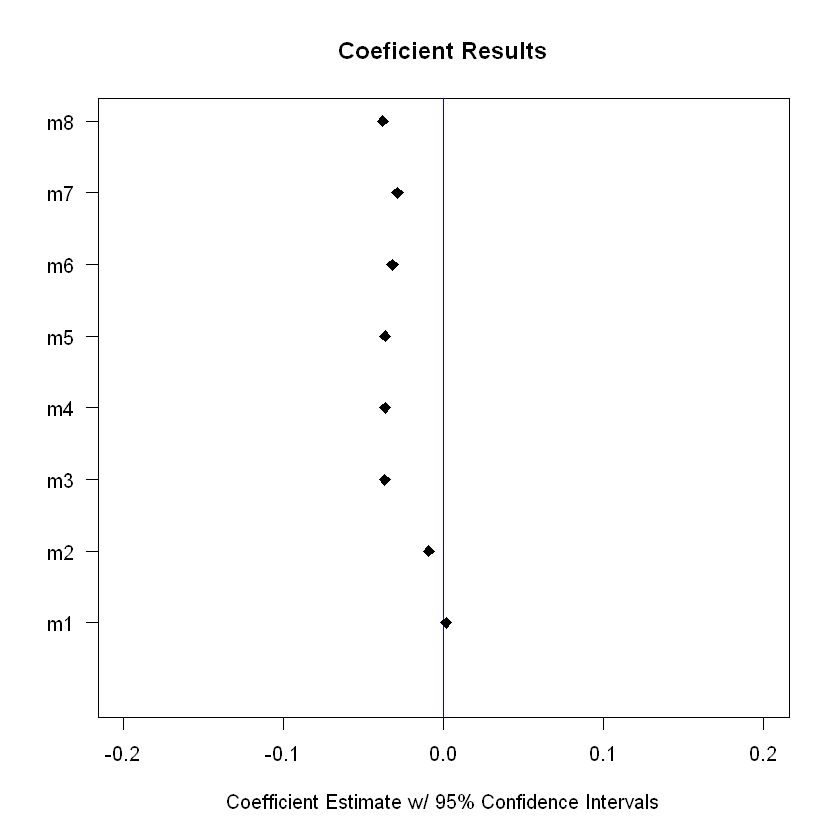

In [2]:
library (dplyr)

plot(NA, xlim = c(-0.2, 0.2), ylim = c(0,8), xlab = "Coefficient Estimate w/ 95% Confidence Intervals", ylab = "", yaxt = "n")
title("Coeficient Results")

axis(2, 1:8, c("m1", "m2", "m3", "m4", "m5", "m6", "m7", "m8"), las = 2)
abline(v = 0, col = "blue")

points(est_baseline , 1, pch = 23, col = "black", bg= "black")
points(est_ols, 2, pch =23, col = "black", bg= "black")
points(DML2.lasso_coef.est, 3, pch =23, col = "black", bg= "black")
points(DML2.post_coef.est, 4, pch =23, col = "black", bg= "black")
points(DML2.elnet_coef.est, 5, pch =23, col = "black", bg= "black")
points(DML2.ridge_coef.est, 6, pch =23, col = "black", bg= "black")
points(DML2.RF_coef.est, 7, pch =23, col = "black", bg= "black")
points(DML2.best_coef.est, 8, pch =23, col = "black", bg= "black")


## CONCLUSIONS

In conclusion, Cross - Validation Elnet is the best method in comparison with the other ones (OLS, OLS with countries characteristics, Lasso, Post-Lasso, CV Elnet & Random Forest), because it give us the lowest RMSE in Y and D matrix variables. According to CV Elnet, our coefficient is $ \beta_1 = -0.038172960 $, which means that poor countries grow faster than rich countries.